# Analysis of bottle data & machine learning model development
Created by Ivan Lima on Tue Aug  3 2021 09:30:47 -0400

In this notebook we examine the merged bottle and satellite data and develop machine learning models to estimate DIC and total alkalitiny from that data.

We develop and compare three different machine learning models:

- Random forest regression
- Gradient boosting regression
- Neural network regression

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Oct  5 14:25:43 2021


In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5]})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Examine the data

In [3]:
# read data
df = pd.read_csv('data/bottle_satellite_data.csv', parse_dates=['Date'], index_col=0)
df['bottom_depth'] = df.bottom_depth.abs() # convert negative to positive values
df['log_Chl'] = np.log(df.Chl)     # log-transformed Chl
df['log_KD490'] = np.log(df.KD490) # log-transformed KD490

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 3039
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2748 non-null   int64         
 1   X.y                  2748 non-null   int64         
 2   DOI                  2748 non-null   object        
 3   EXPOCODE             1473 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2029 non-null   object        
 6   Date                 2748 non-null   datetime64[ns]
 7   Year                 2748 non-null   int64         
 8   Month                2748 non-null   int64         
 9   Day                  2748 non-null   int64         
 10  Time_UTC             2668 non-null   object        
 11  Latitude             2748 non-null   float64       
 12  Longitude            2748 non-null   float64       
 13  Depth_bottom         1488 non-nul

In [4]:
all_vars = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave',
            'SLA', 'SST_hires', 'log_Chl', 'log_KD490', 'DIC', 'TA']
sel_vars = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave',
            'SLA', 'SST_hires', 'log_Chl', 'DIC', 'TA']
bot_vars = ['Depth', 'Temperature', 'Salinity', 'Oxygen', 'DIC', 'TA']
sat_vars = ['SLA', 'SST_hires', 'log_Chl', 'log_KD490']

def dyear2date(x):
    '''Convert decimal year to datetime date'''
    return datetime.datetime(int(x), 1, 1) + datetime.timedelta(days = (x % 1) * 365)

### Bottle data

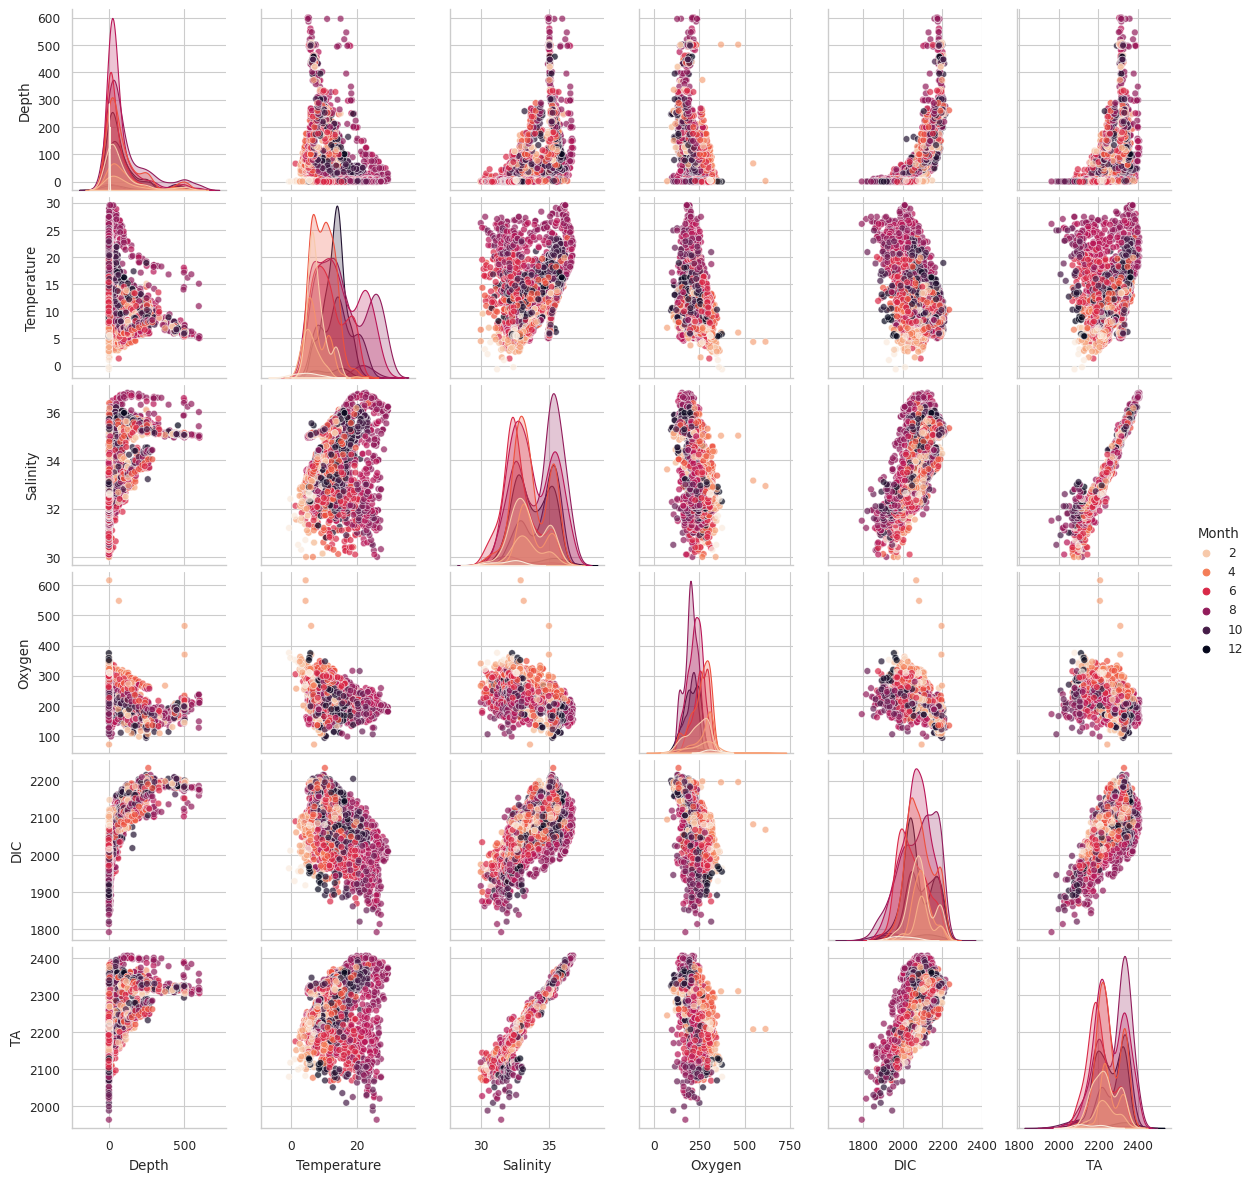

In [5]:
fg = sns.pairplot(df, vars=bot_vars, hue='Month', palette='rocket_r', height=2, plot_kws={'alpha':0.7})

In [6]:
# fg = sns.pairplot(df, vars=['Temperature', 'Salinity', 'Oxygen', 'DIC', 'TA'], hue='Depth', palette='rocket_r',
#                   corner=True, height=2, plot_kws={'alpha':0.7})

### Satellite data at bottle locations

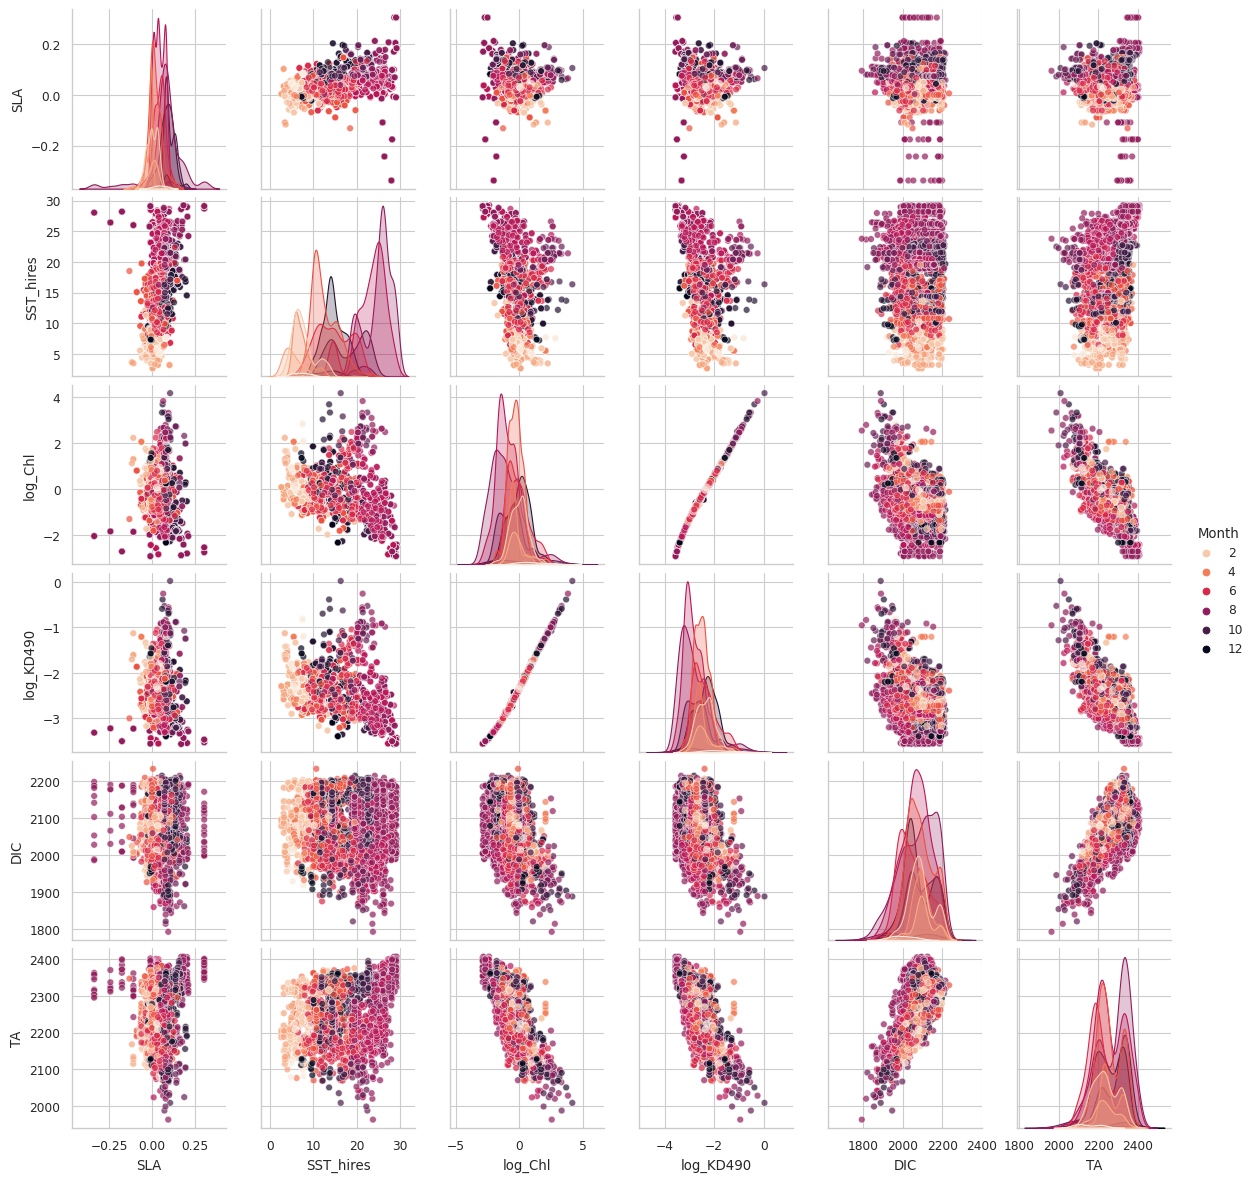

In [7]:
fg = sns.pairplot(df, vars=sat_vars+['DIC','TA'], hue='Month', palette='rocket_r', height=2, plot_kws={'alpha':0.7})

### Bottle & satellite data

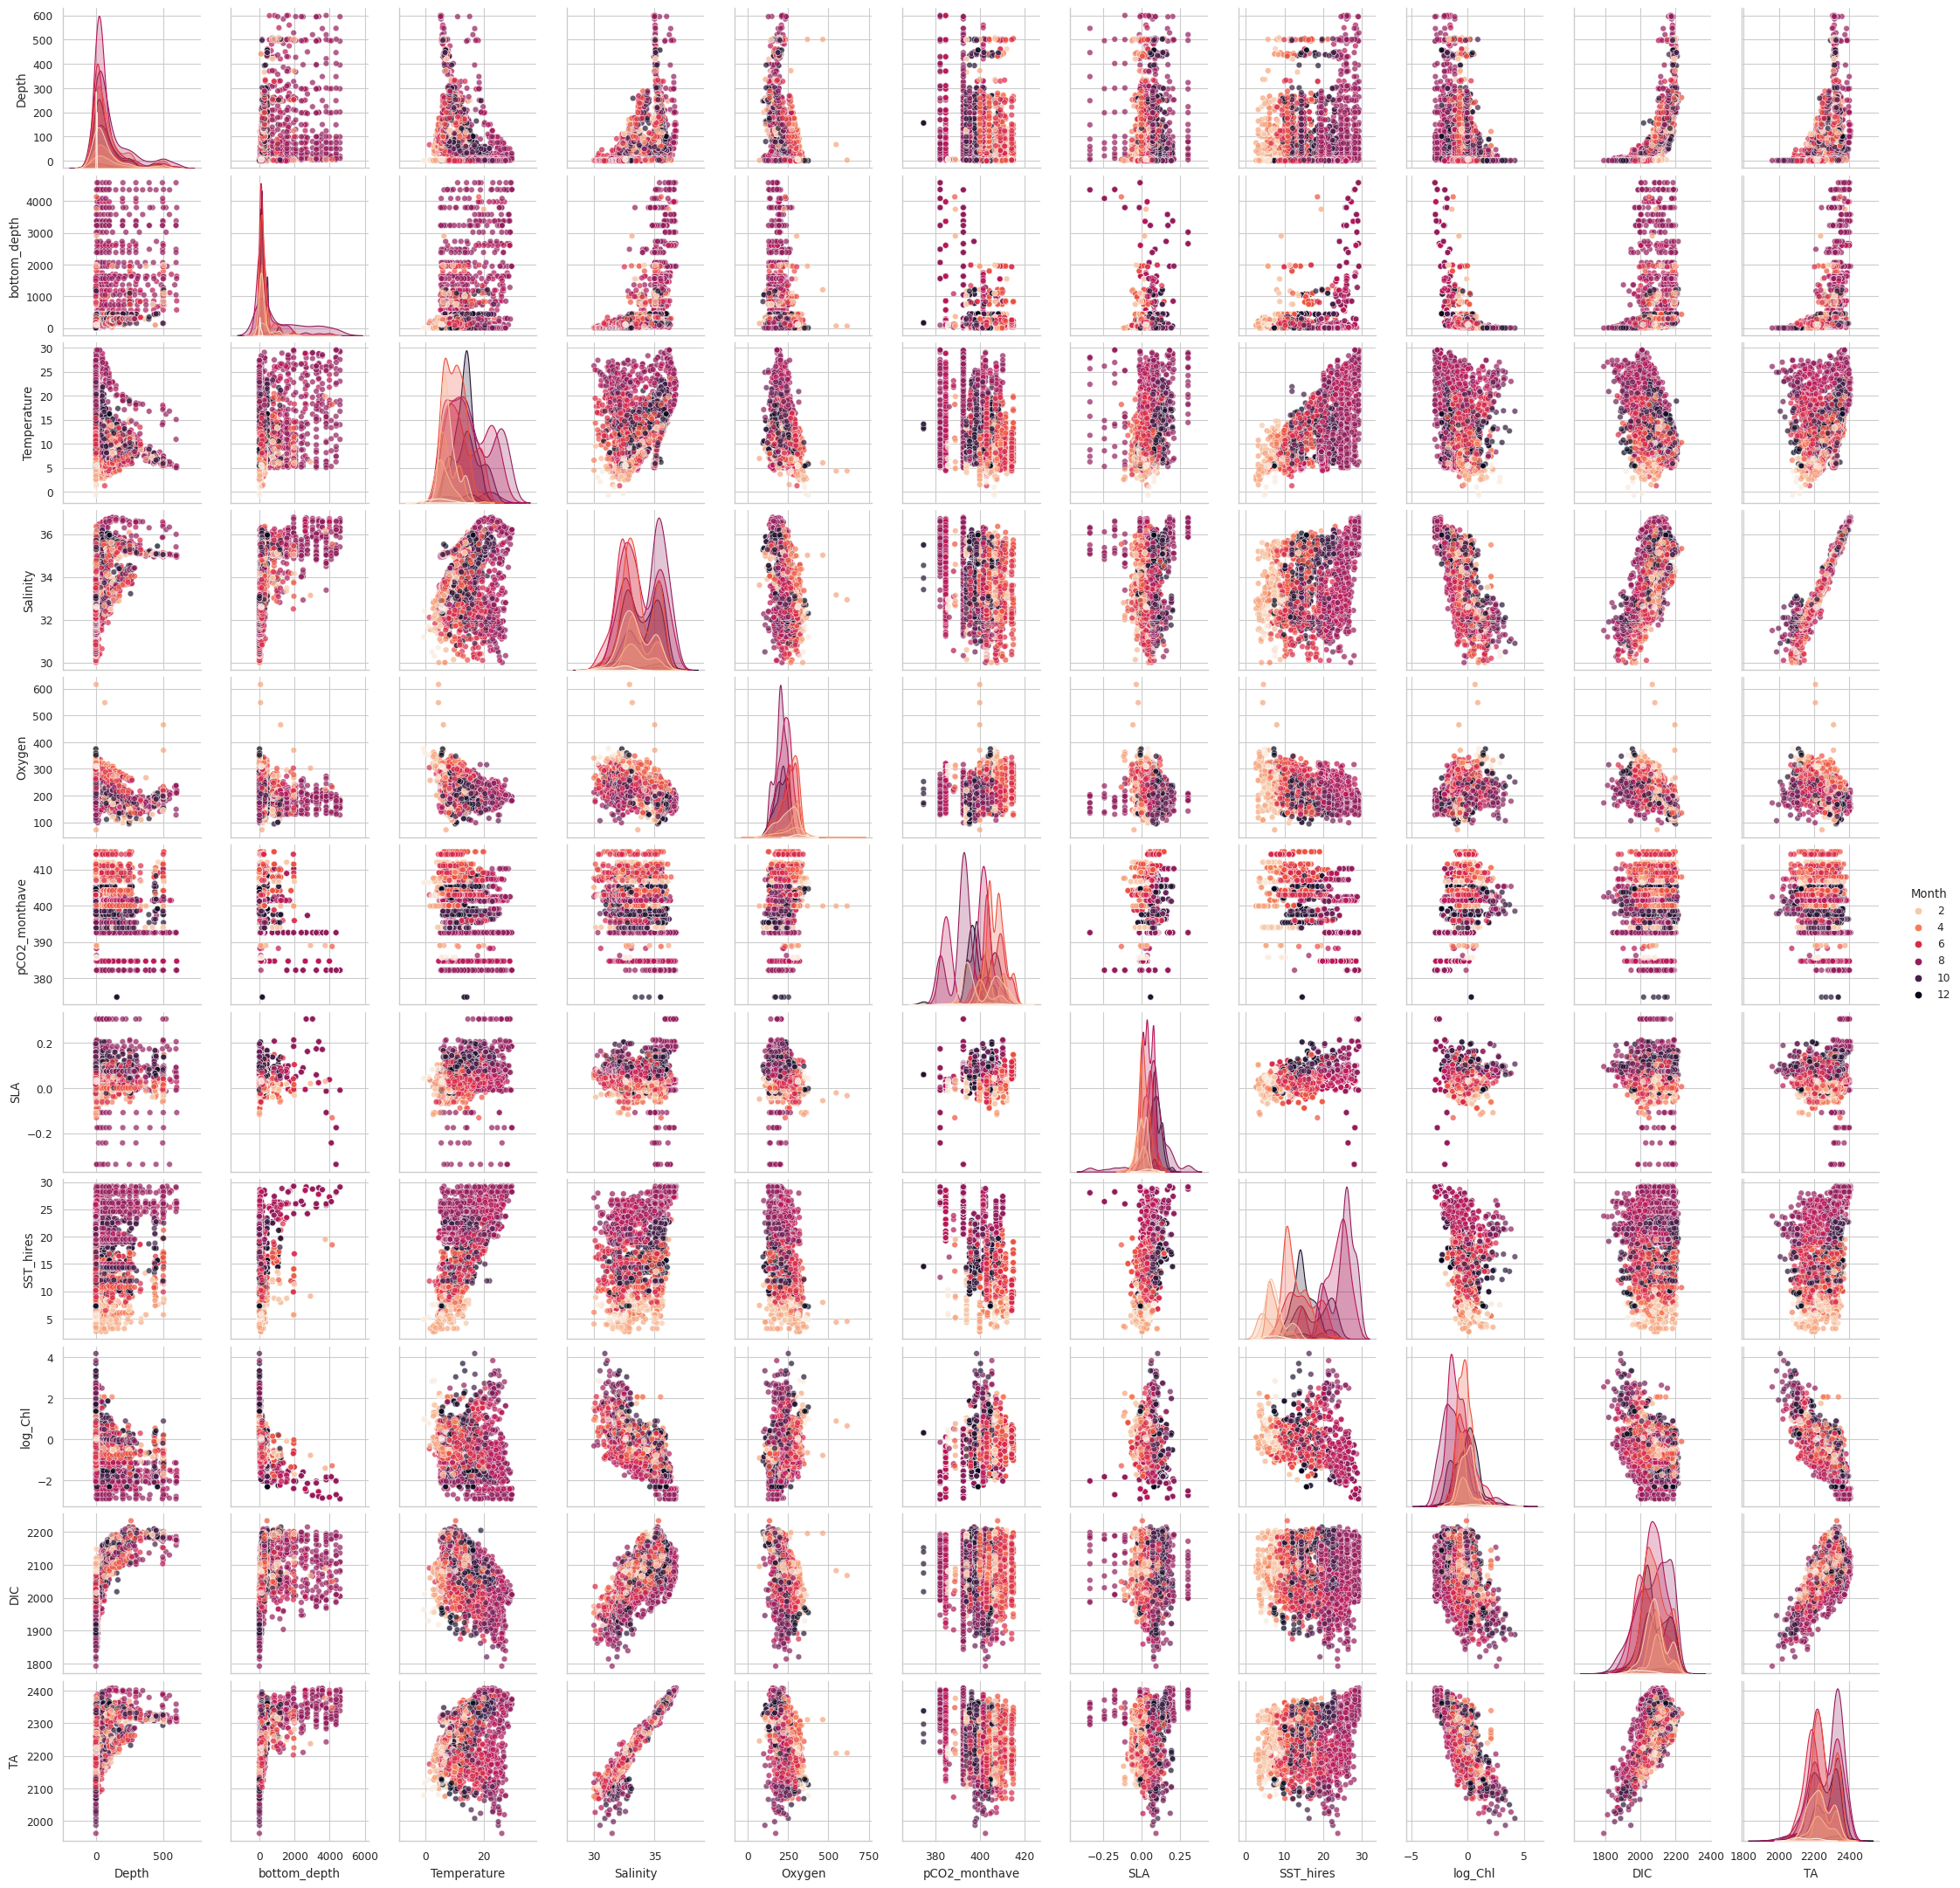

In [8]:
fg = sns.pairplot(df, vars=sel_vars, hue='Month', palette='rocket_r', height=2, plot_kws={'alpha':0.7})

### Mauna Loa pCO$_2$ data

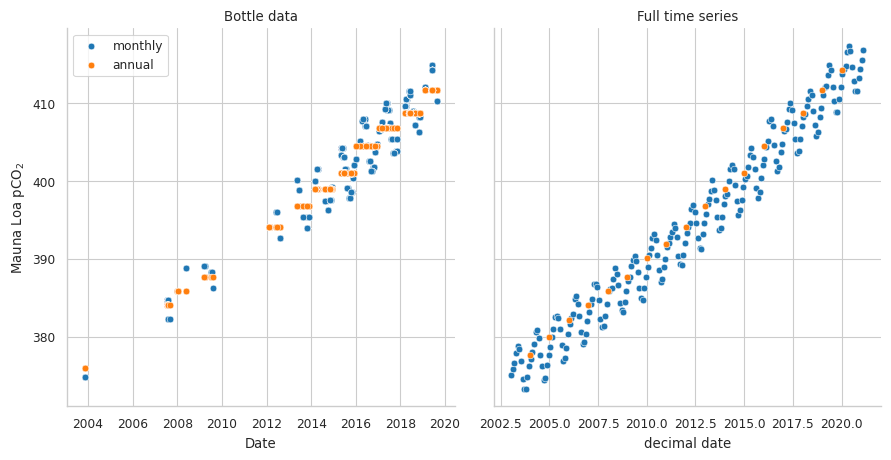

In [9]:
df_co2_annual = pd.read_csv('work/co2_annmean_mlo.csv')
df_co2_monthly = pd.read_csv('work/co2_mm_mlo.csv')
df_co2_annual = df_co2_annual[df_co2_annual.year>2003]
df_co2_monthly = df_co2_monthly[df_co2_monthly['decimal date']>2003]

fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10.5, 5))
fig.subplots_adjust(wspace=0.1)
_ = sns.scatterplot(x='Date', y='pCO2_monthave', data=df, ax=axs[0], label='monthly')
_ = sns.scatterplot(x='Date', y='pCO2_yearave', data=df, ax=axs[0], label='annual')
_ = sns.scatterplot(x='decimal date', y='average', data=df_co2_monthly, ax=axs[1])
_ = sns.scatterplot(x='year', y='mean', data=df_co2_annual, ax=axs[1])
_ = axs[0].set(ylabel='Mauna Loa pCO$_2$', title='Bottle data')
_ = axs[1].set(title='Full time series')
sns.despine(fig)

## Machine Learning models

Models to compare:

- Random Forest regression
- Gradient Boosting regression
- Neural Network regression

To optimize model performance, we tune each model's parameters by searching through parameter space using k-fold cross-validation to evaluate the model's generalization performance.

KD490 and Chl are highly correlated with each other. Using KD490 instead of Chl improves training, test and generalization scores a little bit.

### Select input features and split data into training and test sets 

In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X = df[features].values
Y = df[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

### Correlation between feature and target variables 

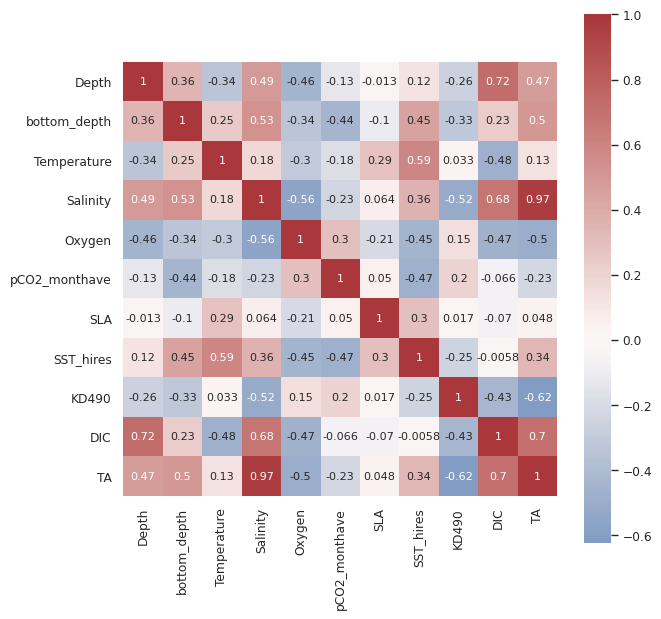

In [11]:
data = df[features + targets]
corr_mat = data.corr()
fig, ax = plt.subplots(figsize=(7,7))
_ = sns.heatmap(corr_mat, ax=ax, cmap='vlag', center=0, square=True, annot=True, annot_kws={'fontsize':8})

### Random Forest regression 

Best cross-validation score: 0.9650
Best parameters: {'max_features': 'sqrt', 'n_estimators': 1100}
Best estimator: RandomForestRegressor(max_features='sqrt', n_estimators=1100, random_state=0)
Training set score: 0.9954
Test set score:     0.9645
Final model cross-validation mean score: 0.9019


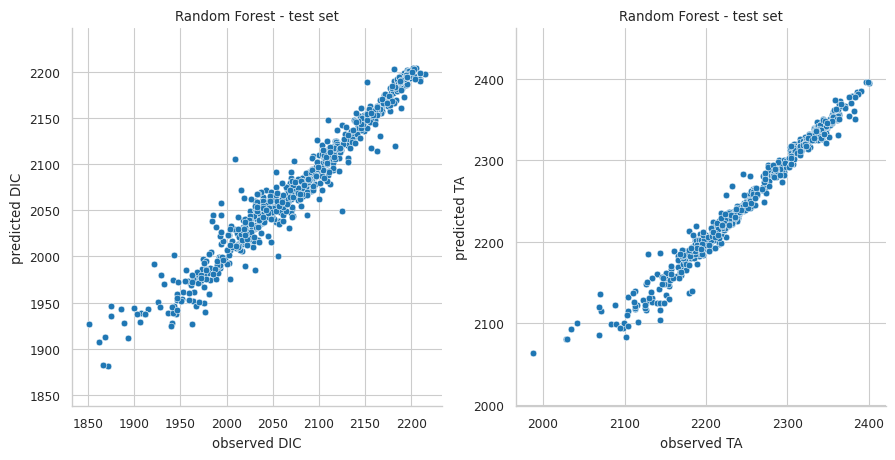

In [12]:
from sklearn.ensemble import RandomForestRegressor

# rfr = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
# rfr.fit(X_train, Y_train)
# print('Training score: {:.4f}'.format(rfr.score(X_train, Y_train)))
# print('Test score:     {:.4f}'.format(rfr.score(X_test, Y_test)))

param_grid = {'n_estimators': [700, 900, 1100],
              'max_features' : [None, 'sqrt', 'log2']}
gs_rfr = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=5, n_jobs=-1)
gs_rfr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_rfr.best_score_))
print('Best parameters: {}'.format(gs_rfr.best_params_))
print('Best estimator: {}'.format(gs_rfr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_rfr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_rfr.score(X_test, Y_test)))

scores = cross_val_score(gs_rfr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_rfr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Random Forest - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Random Forest - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

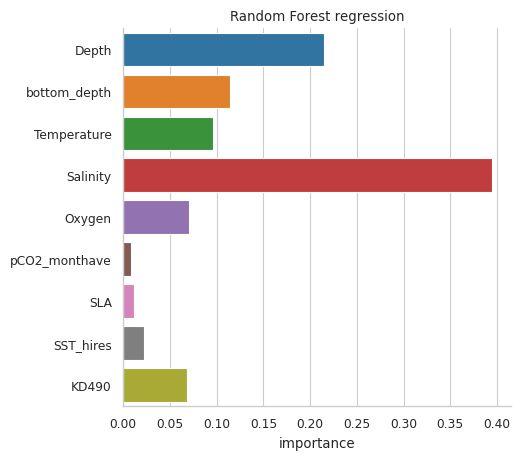

In [13]:
df_rfr = pd.DataFrame(gs_rfr.best_estimator_.feature_importances_, index=features, columns=['importance'])
fig, ax = plt.subplots()
_ = sns.barplot(data=df_rfr, y=df_rfr.index, x='importance', orient='horizontal', ax=ax)
_ = ax.set_title('Random Forest regression')
sns.despine(fig)

### Gradient Boosting regression 

Gradient boosting regression does not support multiple outputs so here we try two different approaches to estimate DIC and TA:

1. **Independent regressors**: Fit one regressor per target. This assumes that DIC and TA are independent from each other.
2. **Chained regressors**: Combine the regressors into a sequencial chain, where we first use the input features to predict one target and then use the input features + first target to predict the second target. This approach takes into account the fact the DIC and TA are correlated. We do this in two different ways:
    1. Use the input features to predict TA, and then use the input features + TA to predict DIC.
    2. Use the input features to predict DIC, and then use the input features + DIC to predict TA.

#### Independent regressors

Best cross-validation score: 0.9713
Best parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 4, 'estimator__n_estimators': 2200}
Best estimator: MultiOutputRegressor(estimator=GradientBoostingRegressor(max_depth=4,
                                                         n_estimators=2200,
                                                         random_state=0))
Training set score: 0.9999
Test set score:     0.9707
Final model cross-validation mean score: 0.9235


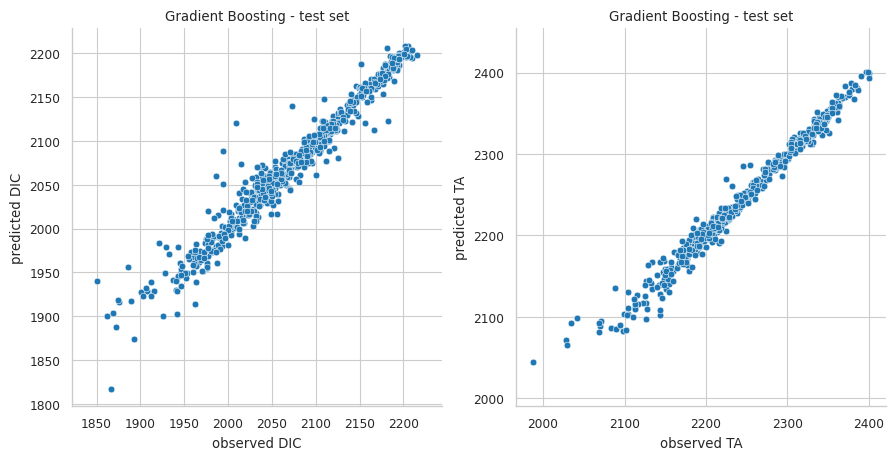

In [14]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

# gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42, n_estimators=900, max_depth=4), n_jobs=-1)
# gbr.fit(X_train, Y_train)
# print('Training score: {:.4f}'.format(gbr.score(X_train, Y_train)))
# print('Test score:     {:.4f}'.format(gbr.score(X_test, Y_test)))

param_grid = {'estimator__n_estimators': [1800, 2000, 2200],
              'estimator__learning_rate':[0.01, 0.1],
              'estimator__max_depth':[3, 4]}
gs_gbr = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor(random_state=0)), param_grid, cv=5, n_jobs=-1)
gs_gbr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_gbr.best_score_))
print('Best parameters: {}'.format(gs_gbr.best_params_))
print('Best estimator: {}'.format(gs_gbr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_gbr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_gbr.score(X_test, Y_test)))

scores = cross_val_score(gs_gbr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_gbr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

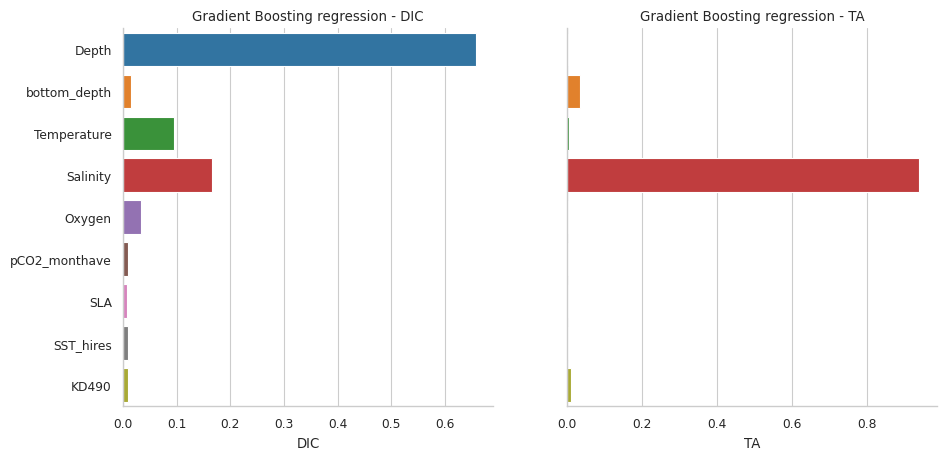

In [15]:
df_gbr = pd.DataFrame(np.c_[gs_gbr.best_estimator_.estimators_[0].feature_importances_,
                            gs_gbr.best_estimator_.estimators_[1].feature_importances_], index=features, columns=['DIC','TA'])
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10.5,5))
_ = sns.barplot(data=df_gbr, y=df_gbr.index, x='DIC', orient='horizontal', ax=axs[0])
_ = sns.barplot(data=df_gbr, y=df_gbr.index, x='TA', orient='horizontal', ax=axs[1])
_ = axs[0].set_title('Gradient Boosting regression - DIC')
_ = axs[1].set_title('Gradient Boosting regression - TA')
sns.despine(fig)

#### Chained regressors

$TA = f(X)$

$DIC = f(X,TA)$

Best cross-validation score: 0.9712
Best parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 4, 'base_estimator__n_estimators': 1700}
Best estimator: RegressorChain(base_estimator=GradientBoostingRegressor(max_depth=4,
                                                        n_estimators=1700,
                                                        random_state=0),
               order=[1, 0])
Training set score: 0.9997
Test set score:     0.9697
Final model cross-validation mean score: 0.9244


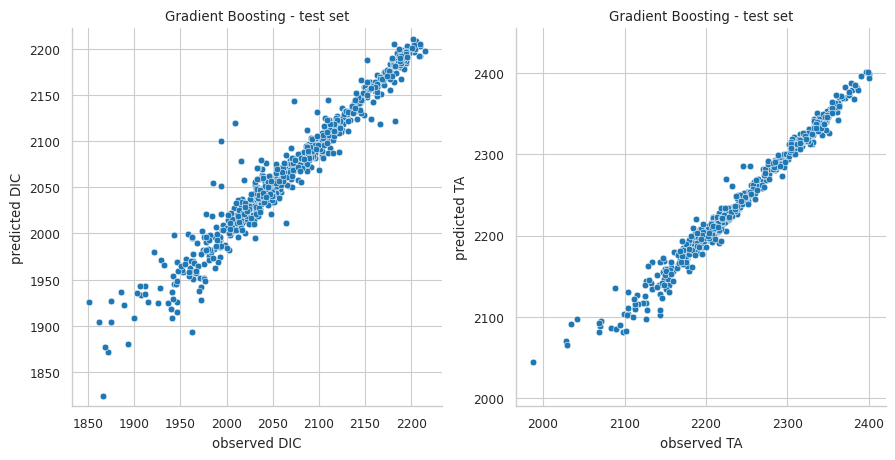

In [16]:
from sklearn.multioutput import RegressorChain

# gbr = RegressorChain(GradientBoostingRegressor(random_state=0, n_estimators=900, max_depth=4), order=[1,0])
# gbr.fit(X_train, Y_train)
# print('Training score: {:.4f}'.format(gbr.score(X_train, Y_train)))
# print('Test score:     {:.4f}'.format(gbr.score(X_test, Y_test)))

# RegressorChain(GradientBoostingRegressor()).get_params()

param_grid = {'base_estimator__n_estimators': [1300, 1500, 1700],
              'base_estimator__learning_rate':[0.01, 0.1],
              'base_estimator__max_depth':[3, 4]}
gs_gbrc = GridSearchCV(RegressorChain(GradientBoostingRegressor(random_state=0), order=[1,0]), param_grid, cv=5, n_jobs=-1)
gs_gbrc.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_gbrc.best_score_))
print('Best parameters: {}'.format(gs_gbrc.best_params_))
print('Best estimator: {}'.format(gs_gbrc.best_estimator_))

print('Training set score: {:.4f}'.format(gs_gbrc.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_gbrc.score(X_test, Y_test)))

scores = cross_val_score(gs_gbrc.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_gbrc.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

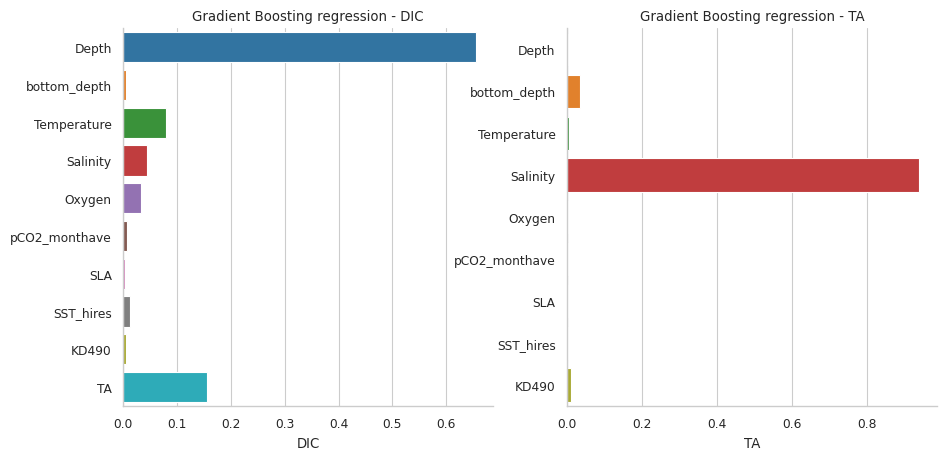

In [17]:
df1 = pd.DataFrame(gs_gbrc.best_estimator_.estimators_[0].feature_importances_, index=features, columns=['TA'])
df2 = pd.DataFrame(gs_gbrc.best_estimator_.estimators_[1].feature_importances_, index=features+['TA'], columns=['DIC'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5,5))
_ = sns.barplot(data=df2, y=df2.index, x='DIC', orient='horizontal', ax=ax0)
_ = sns.barplot(data=df1, y=df1.index, x='TA', orient='horizontal', ax=ax1)
_ = ax0.set_title('Gradient Boosting regression - DIC')
_ = ax1.set_title('Gradient Boosting regression - TA')
sns.despine(fig)

$DIC = f(X)$

$TA= f(X,DIC)$

Best cross-validation score: 0.9708
Best parameters: {'base_estimator__learning_rate': 0.1, 'base_estimator__max_depth': 4, 'base_estimator__n_estimators': 1700}
Best estimator: RegressorChain(base_estimator=GradientBoostingRegressor(max_depth=4,
                                                        n_estimators=1700,
                                                        random_state=0),
               order=[0, 1])
Training set score: 0.9998
Test set score:     0.9701
Final model cross-validation mean score: 0.9204


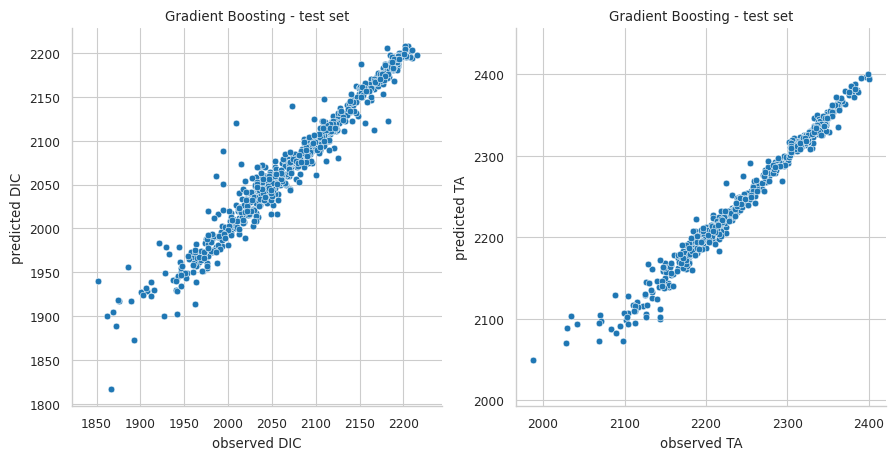

In [18]:
param_grid = {'base_estimator__n_estimators': [1500, 1700, 1900],
              'base_estimator__learning_rate':[0.01, 0.1],
              'base_estimator__max_depth':[3, 4]}
gs_gbrc2 = GridSearchCV(RegressorChain(GradientBoostingRegressor(random_state=0), order=[0,1]), param_grid, cv=5, n_jobs=-1)
gs_gbrc2.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_gbrc2.best_score_))
print('Best parameters: {}'.format(gs_gbrc2.best_params_))
print('Best estimator: {}'.format(gs_gbrc2.best_estimator_))

print('Training set score: {:.4f}'.format(gs_gbrc2.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_gbrc2.score(X_test, Y_test)))

scores = cross_val_score(gs_gbrc2.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_gbrc2.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Gradient Boosting - test set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Gradient Boosting - test set')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

##### Feature importance

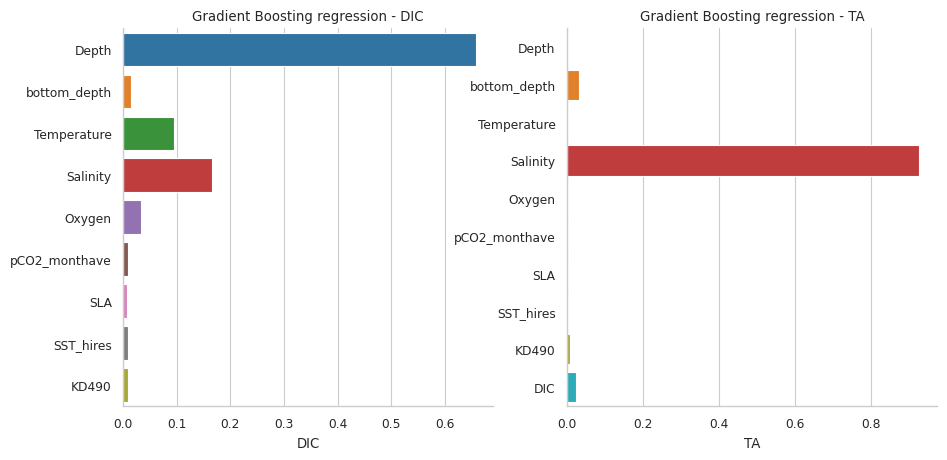

In [19]:
df1 = pd.DataFrame(gs_gbrc2.best_estimator_.estimators_[0].feature_importances_, index=features, columns=['DIC'])
df2 = pd.DataFrame(gs_gbrc2.best_estimator_.estimators_[1].feature_importances_, index=features+['DIC'], columns=['TA'])
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5,5))
_ = sns.barplot(data=df1, y=df1.index, x='DIC', orient='horizontal', ax=ax0)
_ = sns.barplot(data=df2, y=df2.index, x='TA', orient='horizontal', ax=ax1)
_ = ax0.set_title('Gradient Boosting regression - DIC')
_ = ax1.set_title('Gradient Boosting regression - TA')
sns.despine(fig)

### Neural Network regression 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Using log-transformed Chl and KD490 does not change training, test and generalization scores significantly.

Best cross-validation score: 0.9571
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.0001, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=[200],
                              random_state=42, solver='lbfgs'))])
Training set score: 0.9707
Test set score:     0.9524
Final model cross-validation mean score: 0.9000


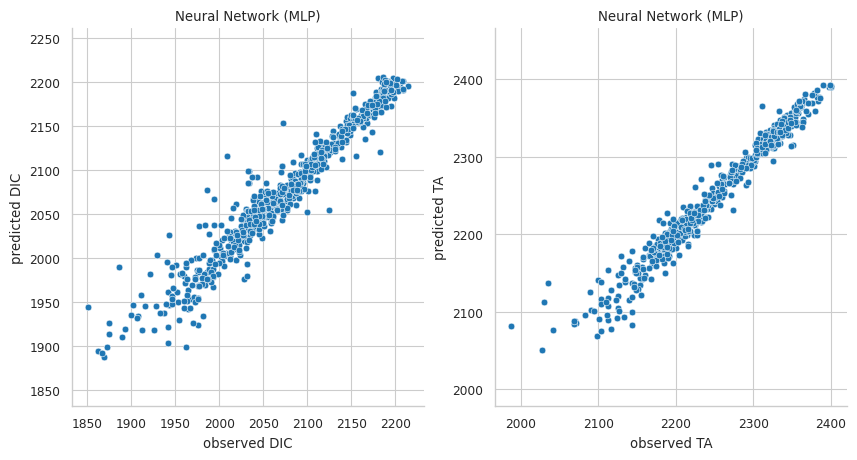

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

#### Feature importance

A possible interpretation of the distribution of hidden node weights is that features that have small (absolute value) weights for all hidden nodes are less important to the model.

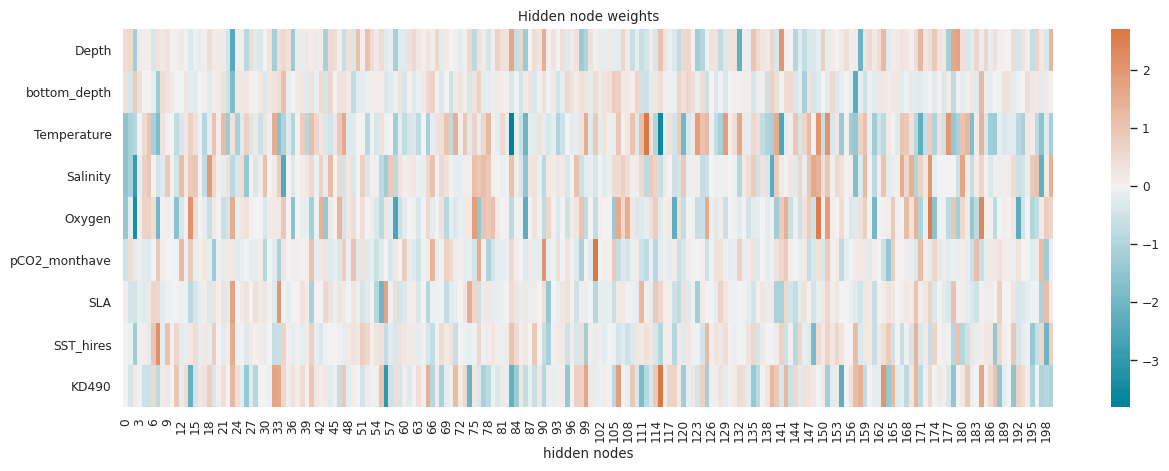

In [21]:
nn_weights = pd.DataFrame(gs_nnr.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=features)
cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap=cmap, ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')

#### Try adding interaction terms as input features

Adding interaction terms does not improve model test and generalization scores significantly.

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(X_poly, Y, random_state=42)

scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
X_poly_scaled = scaler.transform(X_poly)

nnr = gs_nnr.best_estimator_.fit(X_train_poly_scaled, Y_train_poly)
print('Training score: {:.4f}'.format(nnr.score(X_train_poly_scaled, Y_train_poly)))
print('Test score:     {:.4f}'.format(nnr.score(X_test_poly_scaled, Y_test_poly)))
scores = cross_val_score(nnr, X_poly_scaled, Y, cv=5)
print('Cross-validation mean score: {:.4f}'.format(scores.mean()))

Training score: 0.9704
Test score:     0.9535
Cross-validation mean score: 0.9088


Best cross-validation score: 0.9494
Best parameters: {'mlpregressor__activation': 'logistic', 'mlpregressor__alpha': 0.001, 'mlpregressor__hidden_layer_sizes': [200]}
Best estimator: Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(activation='logistic', alpha=0.001,
                              hidden_layer_sizes=[200], random_state=42,
                              solver='lbfgs'))])
Training set score: 0.9708
Test set score:     0.9540
Final model cross-validation mean score: 0.9060


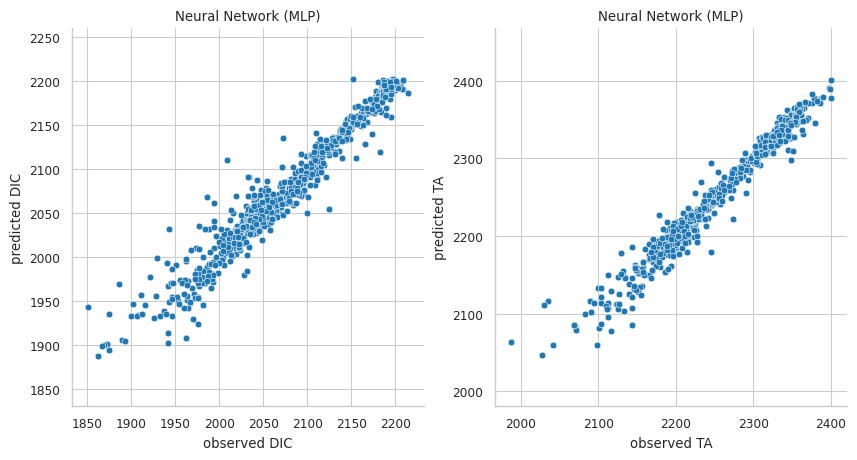

In [23]:
pipe2 = make_pipeline(PolynomialFeatures(interaction_only=True, include_bias=False), StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

gs_nnr2 = GridSearchCV(pipe2, param_grid, cv=5, n_jobs=-1)
gs_nnr2.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr2.best_score_))
print('Best parameters: {}'.format(gs_nnr2.best_params_))
print('Best estimator: {}'.format(gs_nnr2.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr2.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr2.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr2.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr2.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

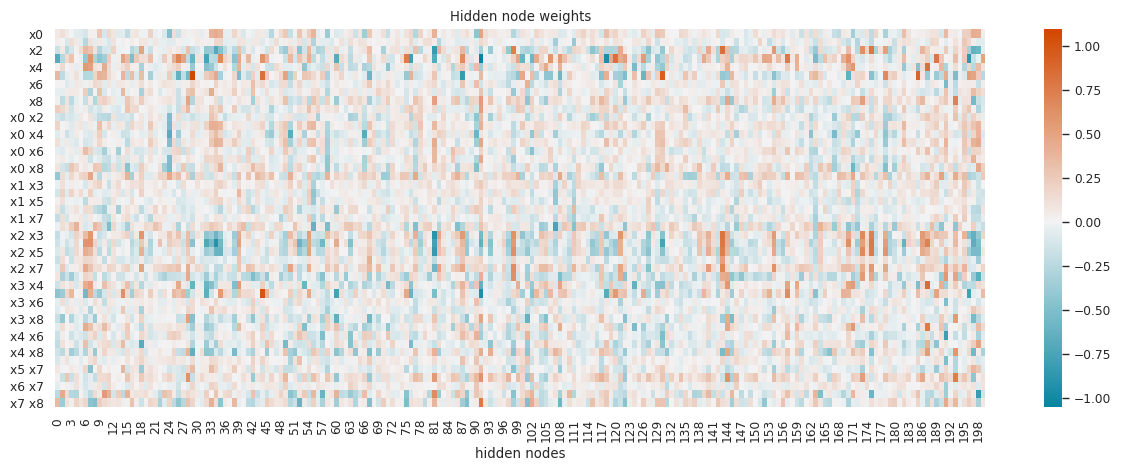

In [24]:
nn_weights = pd.DataFrame(gs_nnr2.best_estimator_.named_steps['mlpregressor'].coefs_[0], index=poly.get_feature_names())
# nn_weights = pd.DataFrame(nnr.coefs_[0], index=poly.get_feature_names())
cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True)
fig, ax = plt.subplots(figsize=(15, 5))
_ = sns.heatmap(nn_weights, center=0, cmap=cmap, ax=ax)
_ = ax.set(xlabel='hidden nodes', title='Hidden node weights')

In [25]:
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_scaled = scaler.transform(X)

# nnr = gs_nnr.best_estimator_.fit(X_train_scaled, Y_train)
# print('Training score: {:.4f}'.format(nnr.score(X_train_scaled, Y_train)))
# print('Test score:     {:.4f}'.format(nnr.score(X_test_scaled, Y_test)))
# scores = cross_val_score(nnr, X_scaled, Y, cv=5)
# print('Cross-validation mean score: {:.4f}'.format(scores.mean()))

In [26]:
# features2 = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490']
# X2 = df[features2].values
# X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y, random_state=42)

# scaler = StandardScaler().fit(X_train2)
# X_train_scaled = scaler.transform(X_train2)
# X_test_scaled = scaler.transform(X_test2)
# X_scaled = scaler.transform(X2)

# nnr = gs_nnr.best_estimator_.fit(X_train_scaled, Y_train)
# print('Training score: {:.4f}'.format(nnr.score(X_train_scaled, Y_train)))
# print('Test score:     {:.4f}'.format(nnr.score(X_test_scaled, Y_test)))
# scores = cross_val_score(nnr, X_scaled, Y, cv=5)
# print('Cross-validation mean score: {:.4f}'.format(scores.mean()))